In [1]:
import os
import gc
import random
import pickle
import math
import time
import itertools

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model

%load_ext autoreload
%autoreload 2
import lib.model as model
import lib.data_processing as dp
import lib.simulator as simulator

In [2]:
# 데이터 로드
ROOT_DIR = "../"
MODEL_DIR = ROOT_DIR + "Model/"
OUTPUT_DIR = ROOT_DIR + "Output/"

DATA_DIR = ROOT_DIR + "Data/"
TRAIN_DIR = DATA_DIR + "spot/usdt/train_20.12.31/"
TEST_DIR = DATA_DIR + "spot/usdt/test_22.05.31/"

train_datas, test_datas = dp.load_data(TRAIN_DIR, TEST_DIR)

DATA kind: 2
BTC (1767253, 4)
DOGE (782985, 4)


(128, 5) (1,)
[1, 2, 4, 8, 16] [64]


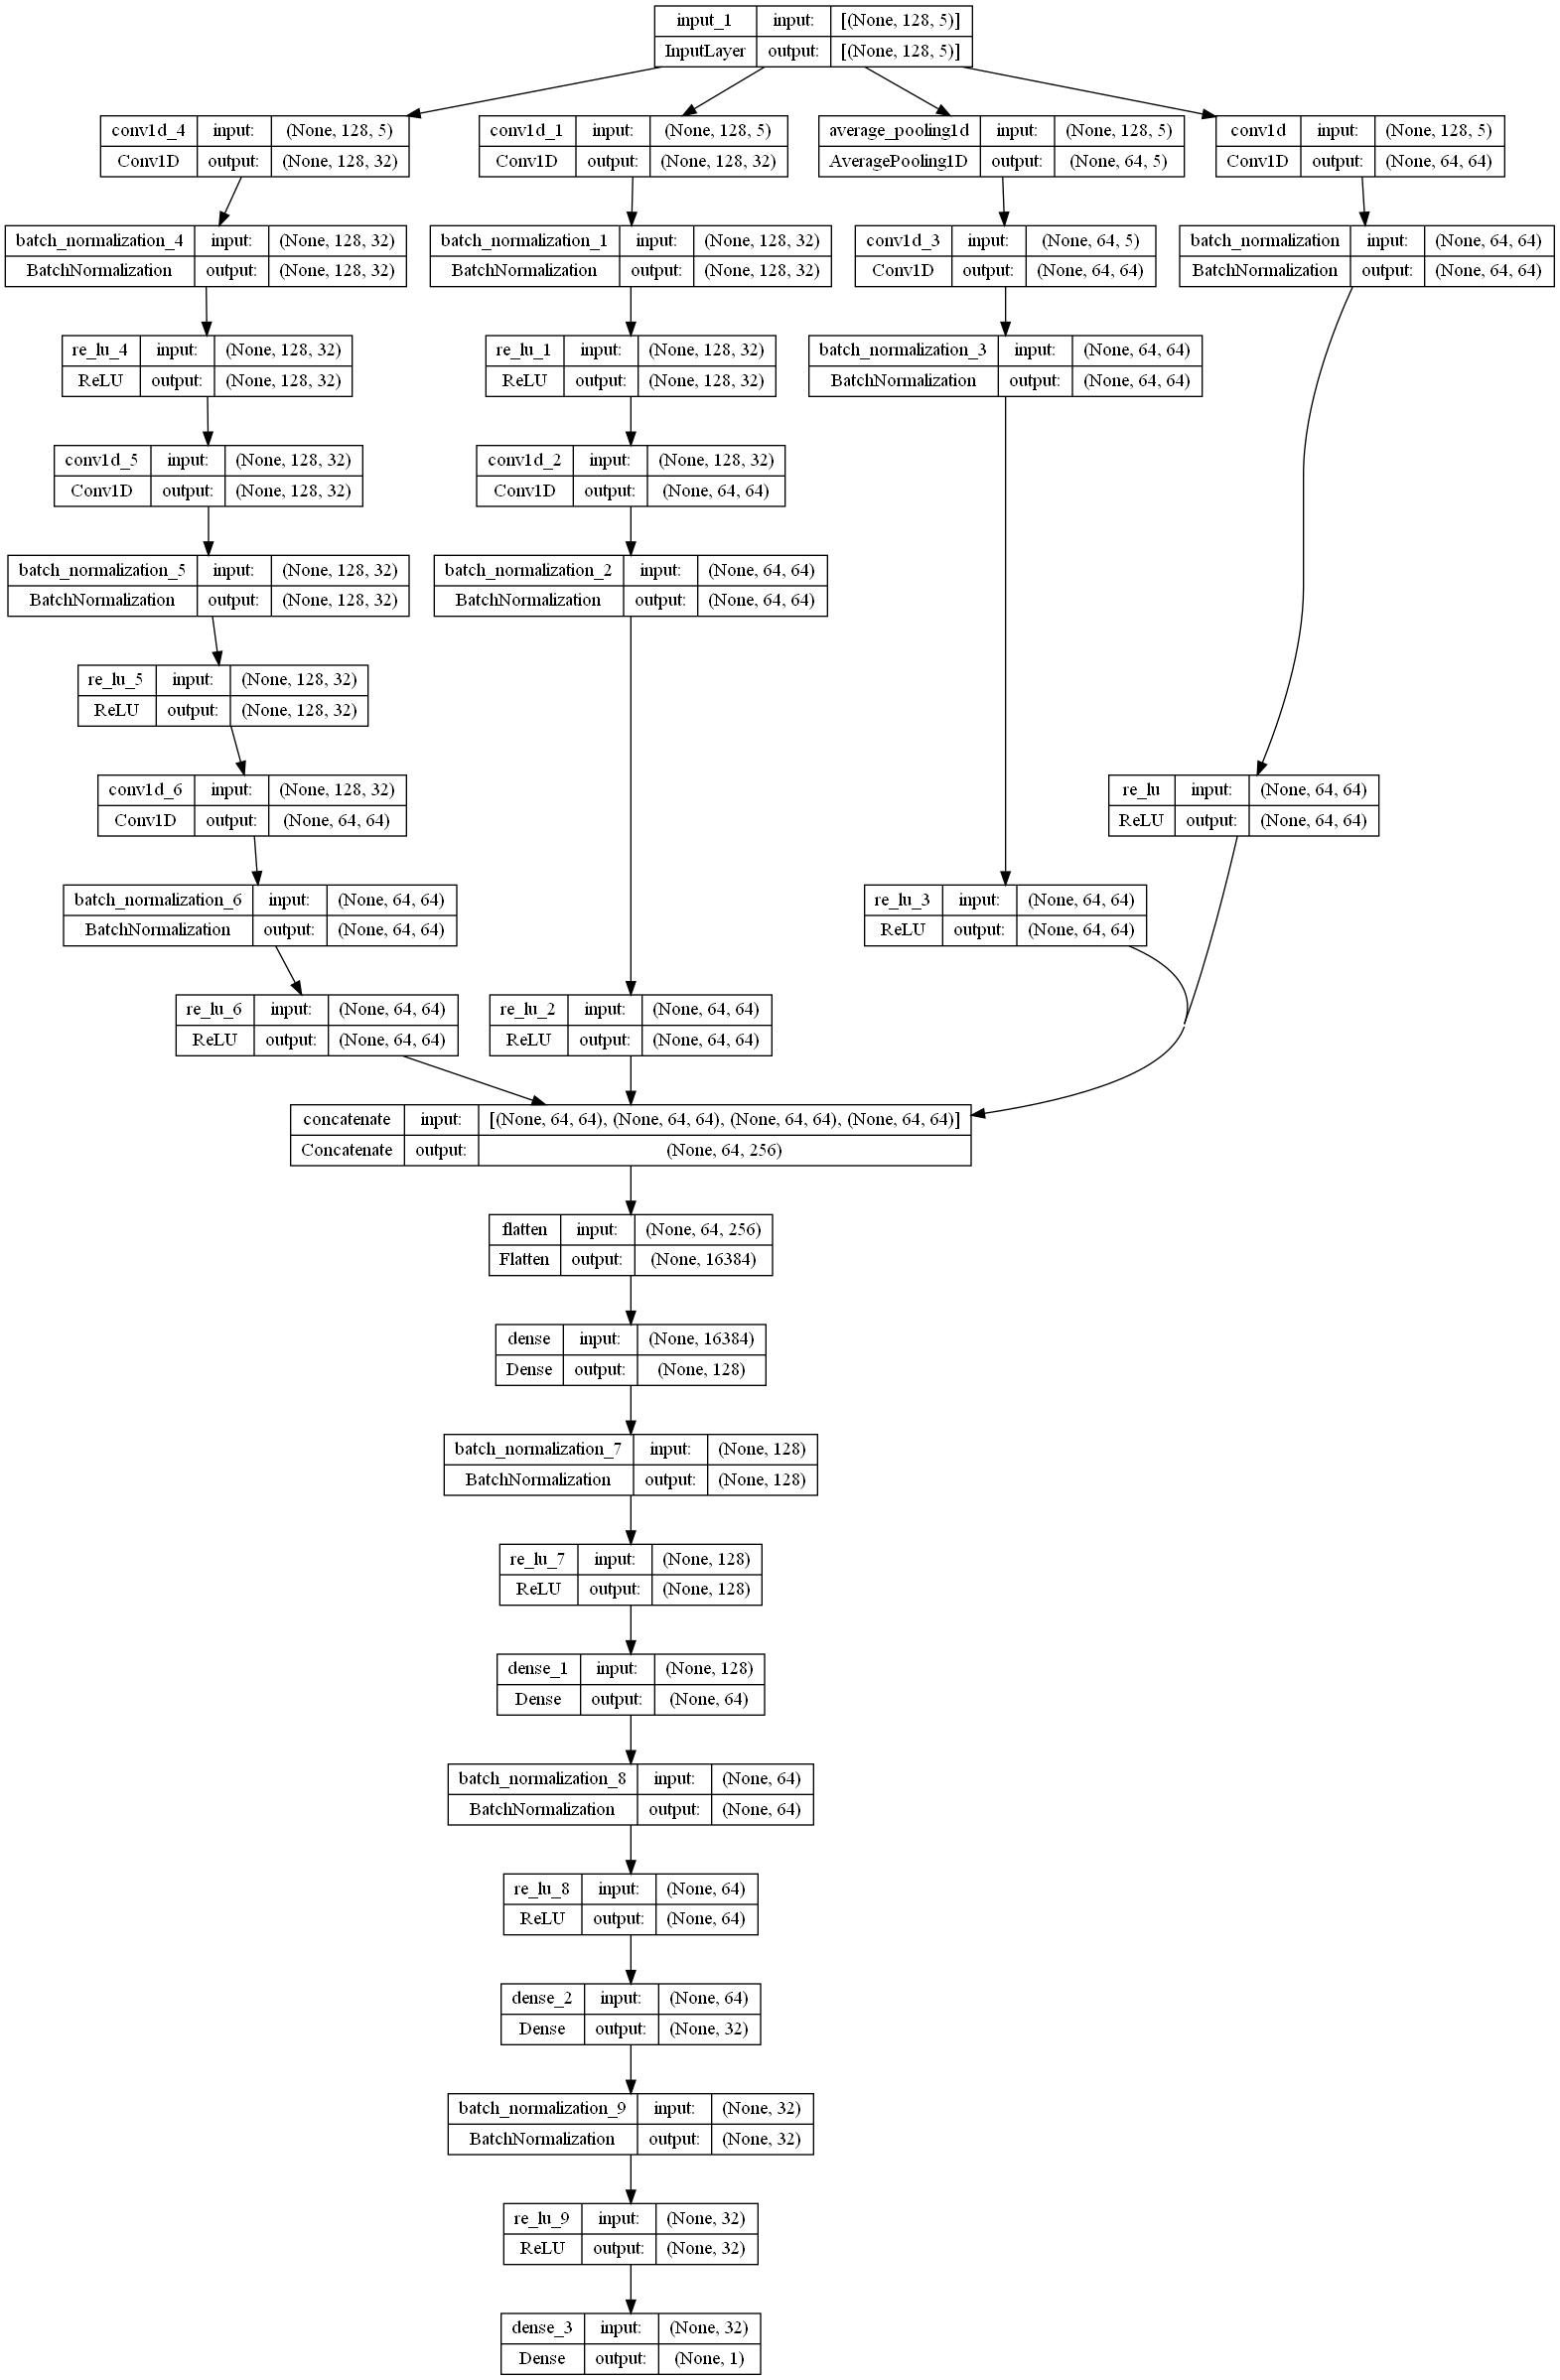

In [3]:
# 모델 정의 및 생성
X_len = 128
y_len = 1

time_windows = [1,2,4,8,16]
y_windows = [64]

X_shape = (X_len, len(time_windows))
y_shape = (len(y_windows),)

print(X_shape, y_shape)
print(time_windows, y_windows)

lr = 1e-3
data_shapes = [X_shape, y_shape]
optimizer = Adam(learning_rate=lr)
loss = 'mse'
metrics = [model.sign_acc]
model_configs = [optimizer, loss, metrics]
predictor = model.inception(data_shapes, model_configs)

# history 초기화
history = {}
history['step'] = 0
history['train_losses'] = []
history['test_losses'] = []
history['train_accs'] = []
history['test_accs'] = []

# 모델 모양 출력
plot_model(predictor, to_file=OUTPUT_DIR + 'model/structure.png', show_shapes=True, expand_nested=True)

In [4]:
# 데이터 로더 정의
batch_size = 1024
datas = (train_datas, test_datas)
data_infos = (batch_size, X_len, y_len, time_windows, y_windows)

dataloader = dp.DataLoader(datas, data_shapes, data_infos)

BTC (1765157,)
DOGE (780889,)
total_size: 2546046
valid_symbols: 2


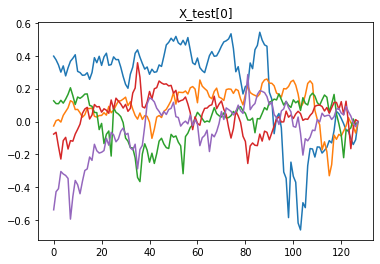

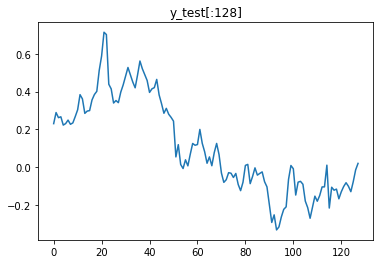

In [5]:
# 테스트 데이터 시각화
plt.clf()
plt.title("X_test[0]")
plt.plot(dataloader.X_test[0,:,:])
plt.show()

plt.clf()
plt.title("y_test[:128]")
plt.plot(dataloader.y_test[0:X_len])
plt.show()

In [ ]:
# 모델 로드
#predictor = load_model(MODEL_DIR + 'X128_5_limit0.54.h5', compile=False) # 가장 수익률이 좋은 모델
predictor = load_model(OUTPUT_DIR + 'model/predictor.h5', compile=False)
predictor.compile(optimizer=optimizer, loss=loss, metrics=metrics)

try:
    with open(OUTPUT_DIR + 'history.pkl', 'rb') as f:
        history = pickle.load(f)
except:
    print("NO history")

step: 1
train_loss: 25.313236, train_acc: 0.562500
test_loss:  32.953968, test_acc:  0.488867
step: 271
train_loss: 0.623231, train_acc: 0.568262
test_loss:  0.872195, test_acc:  0.539746
step: 544
train_loss: 0.642790, train_acc: 0.606445
test_loss:  0.915806, test_acc:  0.478906
step: 821
train_loss: 0.620446, train_acc: 0.577734
test_loss:  0.885355, test_acc:  0.504395
step: 1096
train_loss: 0.598961, train_acc: 0.595703
test_loss:  0.873396, test_acc:  0.539062
step: 1381
train_loss: 0.650117, train_acc: 0.593457
test_loss:  0.891220, test_acc:  0.531934
step: 1660
train_loss: 0.576905, train_acc: 0.594922
test_loss:  0.896913, test_acc:  0.529492
step: 1940
train_loss: 0.555121, train_acc: 0.613477
test_loss:  0.889376, test_acc:  0.508691
step: 2220
train_loss: 0.595512, train_acc: 0.612207
test_loss:  0.945340, test_acc:  0.524902
step: 2496
train_loss: 0.541911, train_acc: 0.586719
test_loss:  0.989007, test_acc:  0.546582
step: 2776
train_loss: 0.531607, train_acc: 0.628906
t

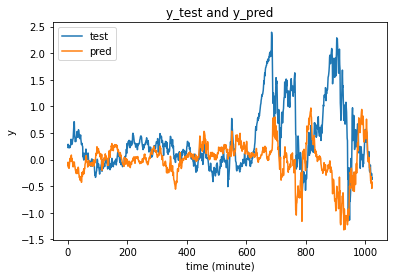

In [6]:
# 학습 진행
X_train = dataloader.X_train; y_train = dataloader.y_train
X_test = dataloader.X_test; y_test = dataloader.y_test

eval_time = time.time()
try:
    while(True):
        X_data, y_data = dataloader.get_train_data()
        predictor.train_on_batch(X_data, y_data)
        history['step'] += 1

        if history['step'] == 1 or time.time() - eval_time > 60:
            eval_time = time.time()
            predictor.save(OUTPUT_DIR + 'model/predictor.h5')
            #lr = lr * (1-0.001)
            K.set_value(predictor.optimizer.learning_rate, lr)

            train_eval = predictor.evaluate(X_train, y_train, verbose=0)
            test_eval = predictor.evaluate(X_test, y_test, verbose=0)
            history['train_losses'].append(train_eval[0])
            history['test_losses'].append(test_eval[0])
            history['train_accs'].append(train_eval[1])
            history['test_accs'].append(test_eval[1])

            print('step: ' + str(history['step']))
            print("train_loss: %f, train_acc: %f" % (history['train_losses'][-1], history['train_accs'][-1]))
            print("test_loss:  %f, test_acc:  %f" % (history['test_losses'][-1], history['test_accs'][-1]))

            plt.clf()
            plt.title("losses")
            plt.xlabel("train time (minute)")
            plt.ylabel("mse")
            plt.plot(history['train_losses'][1:], label="train")
            plt.plot(history['test_losses'][1:], label="test")
            plt.legend()
            plt.draw()
            plt.gcf().savefig(OUTPUT_DIR + 'losses.png')

            plt.clf()
            plt.title("sign accs")
            plt.xlabel("train time (minute)")
            plt.ylabel("sign acc")
            plt.plot(history['train_accs'][1:], label="train")
            plt.plot(history['test_accs'][1:], label="test")
            plt.legend()
            plt.draw()
            plt.gcf().savefig(OUTPUT_DIR + 'accs.png')

            fig_size = 1024
            y_pred = predictor.predict(X_train[:fig_size], verbose=0)
            plt.clf()
            plt.title("y_train and y_pred")
            plt.xlabel("time (minute)")
            plt.ylabel("y")
            plt.plot(y_train[:fig_size], label="train")
            plt.plot(y_pred[:fig_size], label="pred")
            plt.legend()
            plt.draw()
            plt.gcf().savefig(OUTPUT_DIR + 'train' + str(history['step']) + '.png')

            y_pred = predictor.predict(X_test[:fig_size], verbose=0)
            plt.clf()
            plt.title("y_test and y_pred")
            plt.xlabel("time (minute)")
            plt.ylabel("y")
            plt.plot(y_test[:fig_size], label="test")
            plt.plot(y_pred[:fig_size], label="pred")
            plt.legend()
            plt.draw()
            plt.gcf().savefig(OUTPUT_DIR + 'test' + str(history['step']) + '.png')

            with open(OUTPUT_DIR + 'history.pkl', 'wb') as f:
                pickle.dump(history, f)
except KeyboardInterrupt:
    print("Train End")
    predictor.save(OUTPUT_DIR + 'model/predictor.h5')
    with open(OUTPUT_DIR + 'history.pkl', 'wb') as f:
        pickle.dump(history, f)

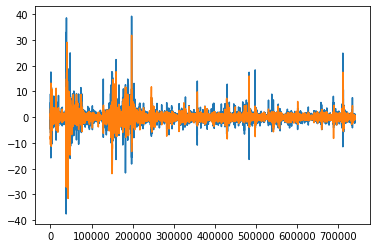

거래횟수: 2179, 2140 회
승률: 60.89949518127582, 64.43925233644859 %
수익률: -99.99510374625808 %


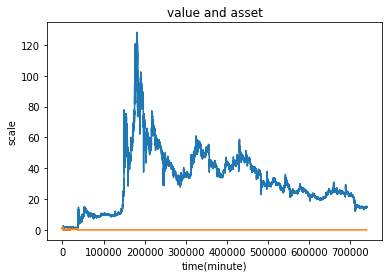

Last y_pred:  [-0.8477175]


In [7]:
# 예측 및 기본 수익률 계산
symbol = "DOGE"
ohlcv_data = test_datas[symbol]
y_data, y_pred = simulator.get_real_pred(predictor, dataloader, symbol)

# 예측 데이터 시각화
plt.clf()
plt.plot(y_data)
plt.plot(y_pred)
plt.show()

# Trader 시뮬레이팅
fee_rate = 0.04 / 100
margin_rate = 3.0
threshold = [0.3, -0.3]
trading_conditions = [fee_rate, margin_rate, threshold]
trader = simulator.TraderFutureMarket(ohlcv_data, y_pred, trading_conditions)

fee_rate = 0.02 / 100
margin_rate = 3.0
threshold = [0.0, 0.0]
limit_rate = 0.54 / 100
trading_conditions = [fee_rate, margin_rate, threshold, limit_rate]
trader = simulator.TraderFutureLimit(ohlcv_data, y_pred, trading_conditions)

trading_info, money_list, value_list = trader.get_yield()

# trade_log, trade_num, win_rate, trading_yield
print("거래횟수: %s, %s 회" % (trading_info[1][0], trading_info[1][1]))
print("승률: %s, %s %%" % (trading_info[2][0], trading_info[2][1]))
trading_yield = (money_list[-1]/money_list[0] - 1) * 100
print("수익률: %s %%" % trading_yield)

# 결과 시각화
plt.clf()
plt.title("value and asset")
plt.xlabel("time(minute)")
plt.ylabel("scale")
plt.plot(value_list/value_list[0])
plt.plot(money_list/money_list[0])

trade_log = np.array(trading_info[0]) * (np.max(value_list)/value_list[0] - np.min(value_list)/value_list[0]) + np.min(value_list)/value_list[0]
plt.show()
print("Last y_pred: ", y_pred[-1])

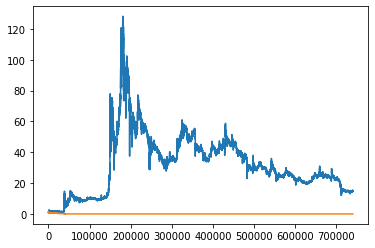

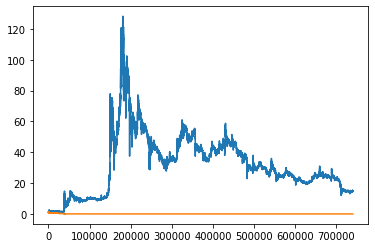

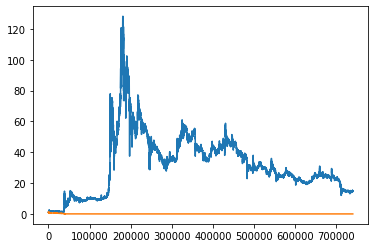

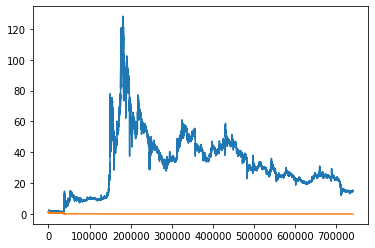

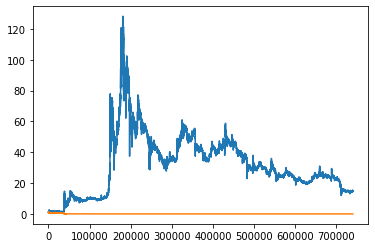

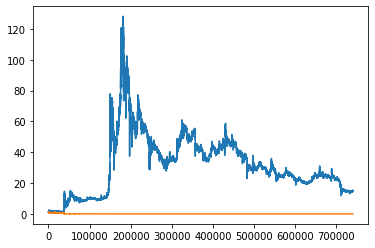

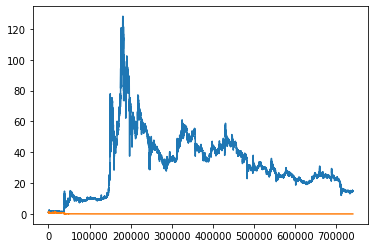

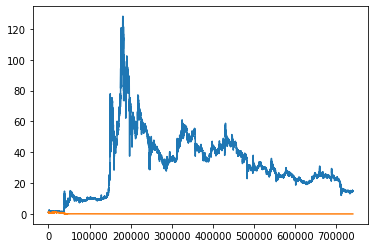

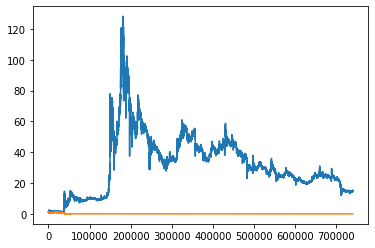

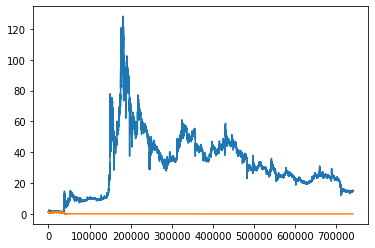

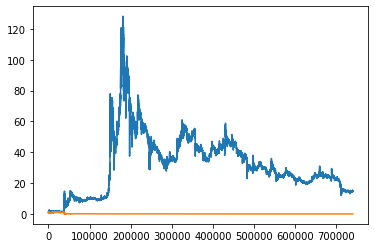

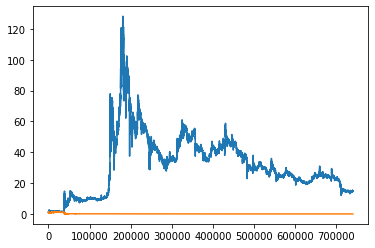

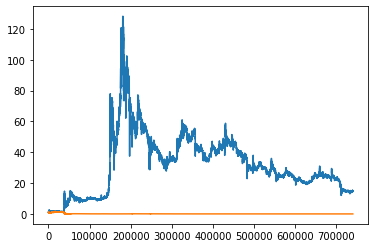

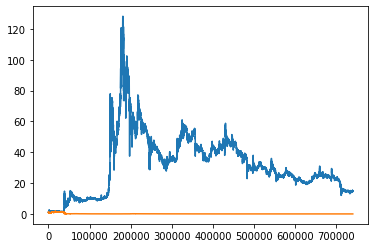

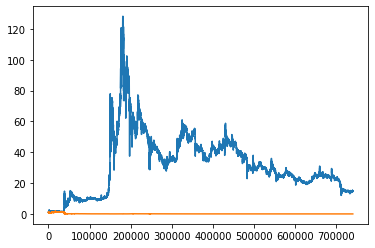

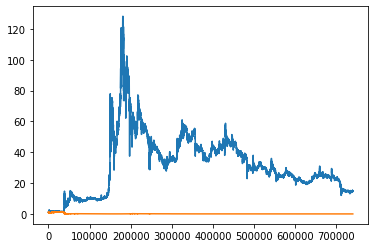

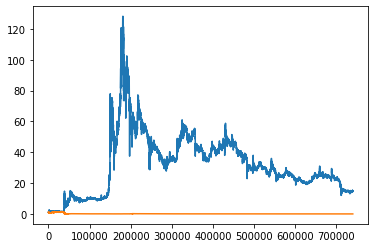

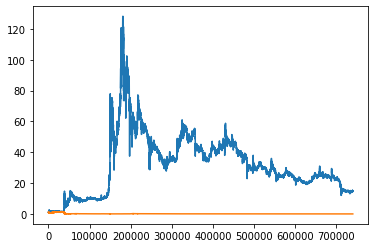

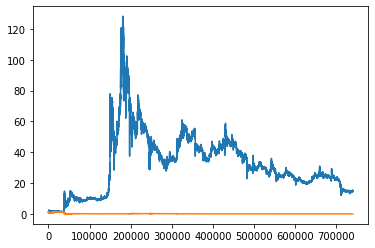

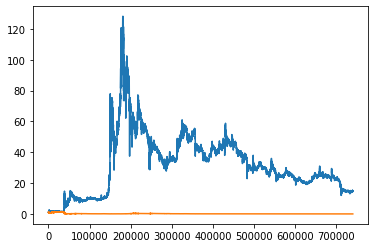

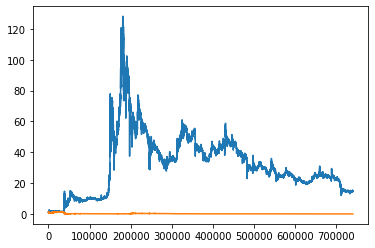

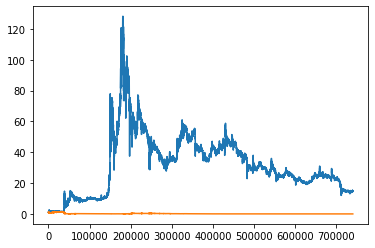

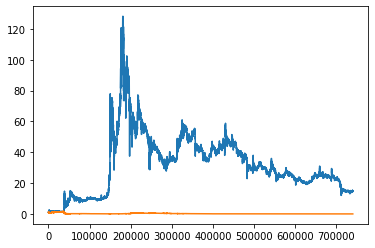

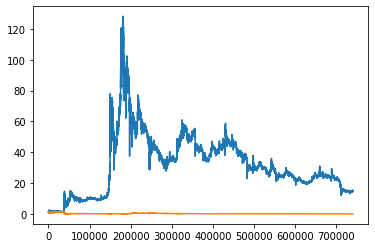

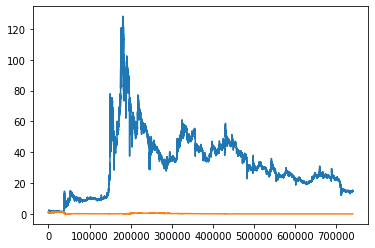

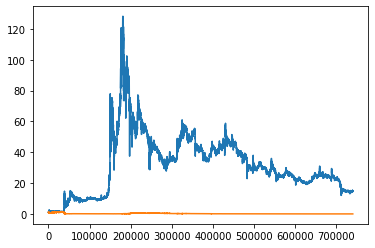

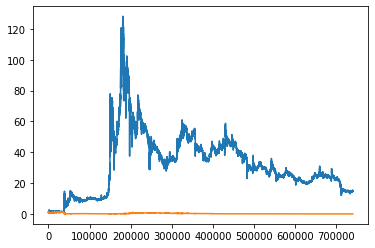

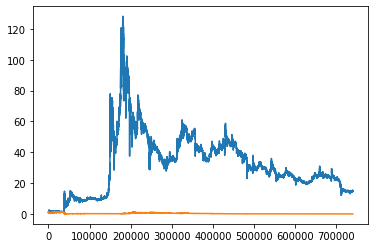

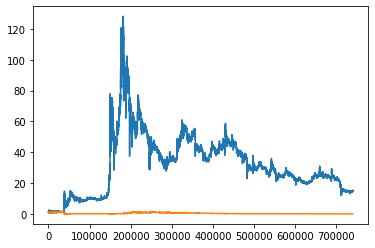

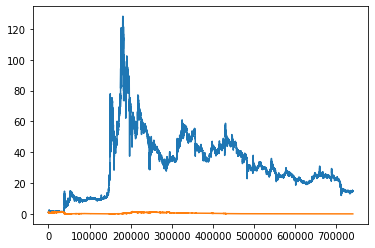

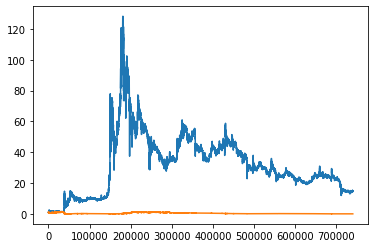

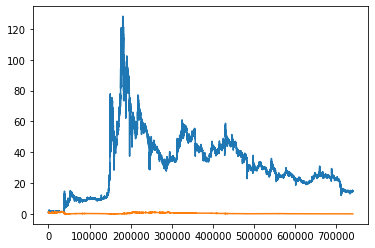

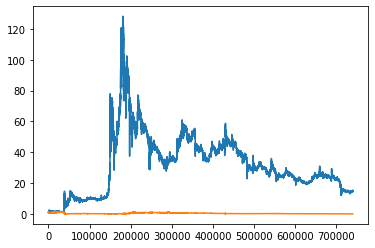

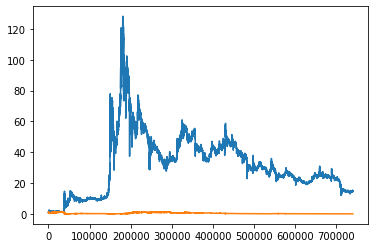

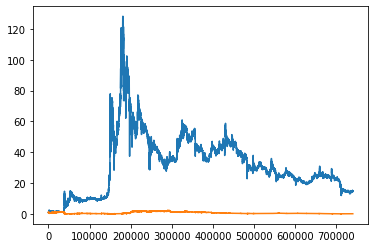

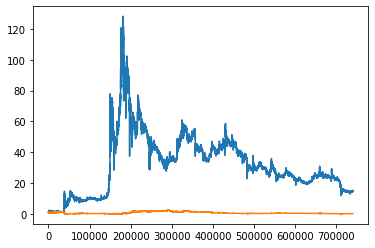

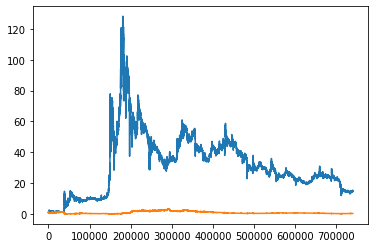

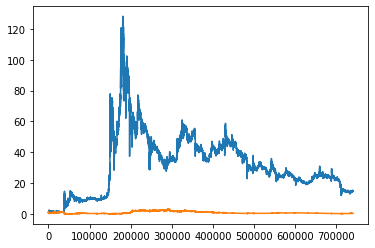

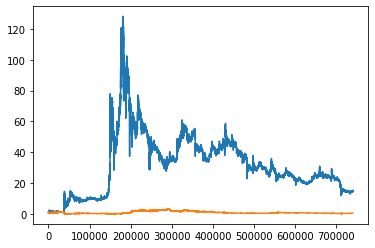

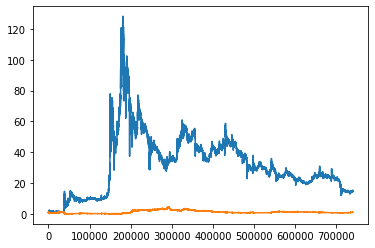

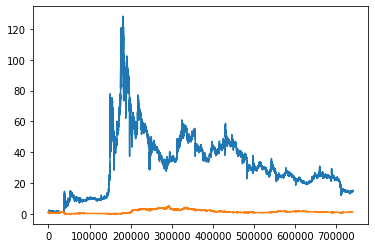

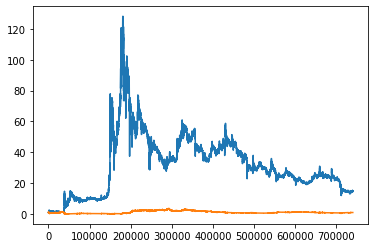

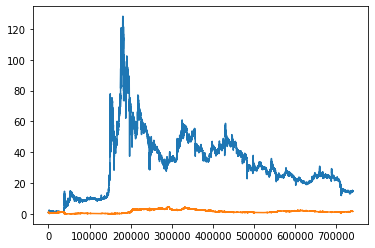

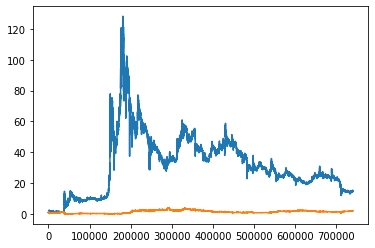

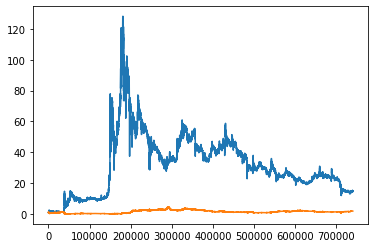

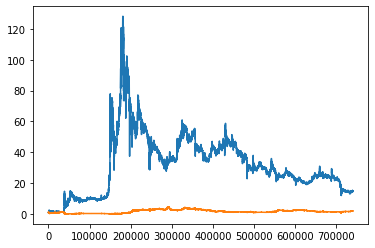

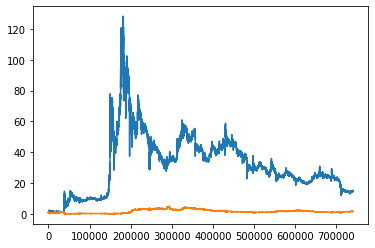

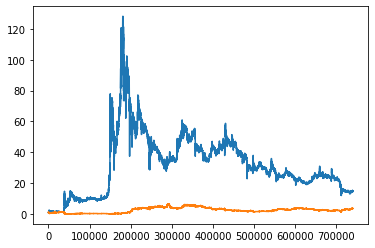

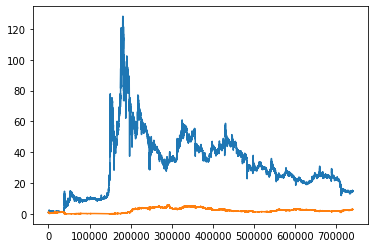

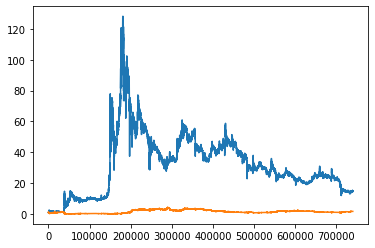

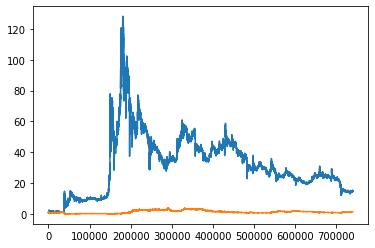

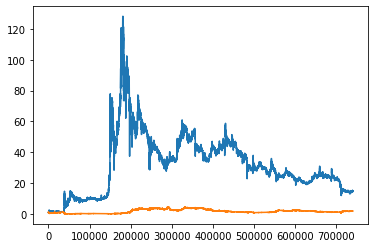

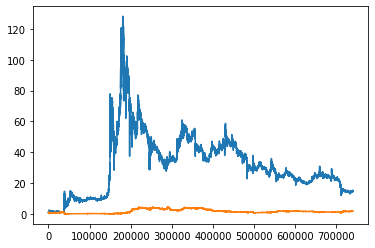

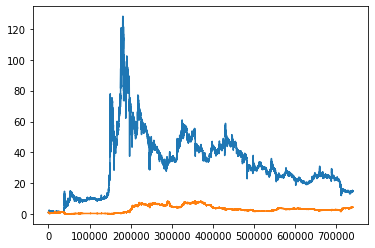

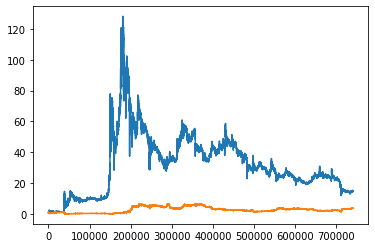

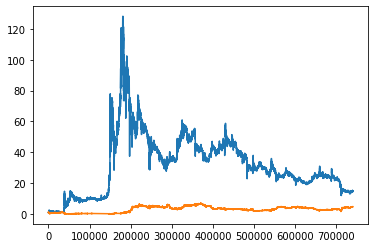

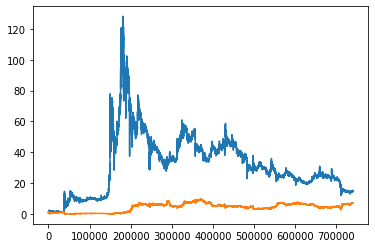

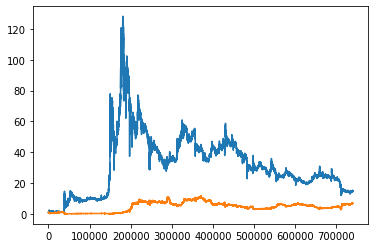

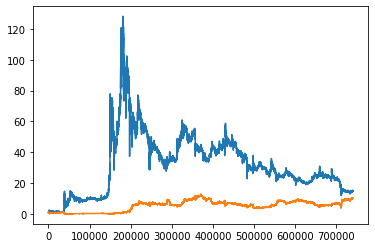

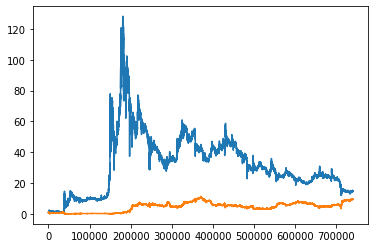

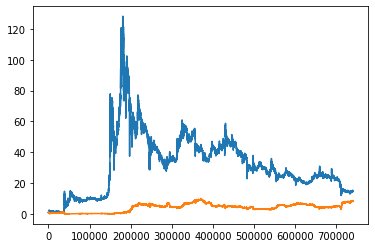

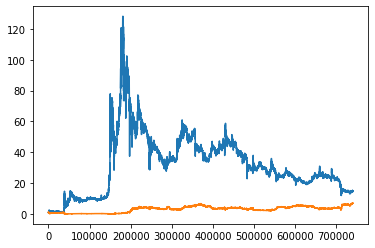

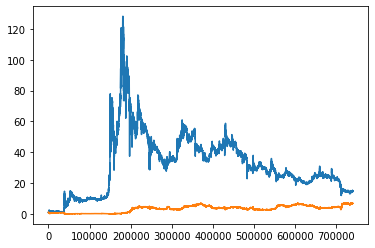

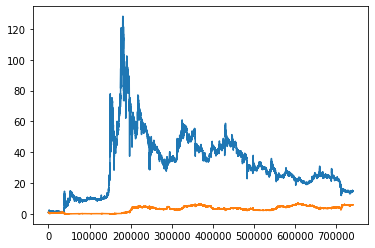

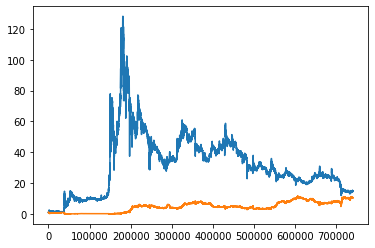

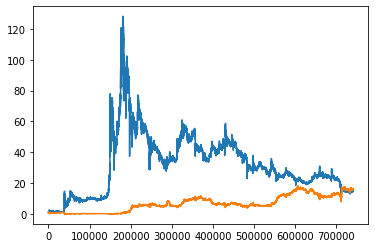

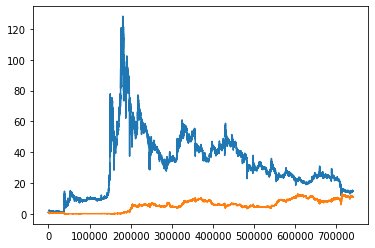

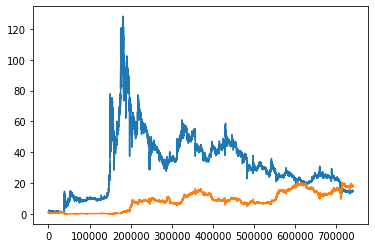

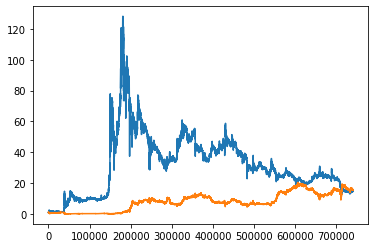

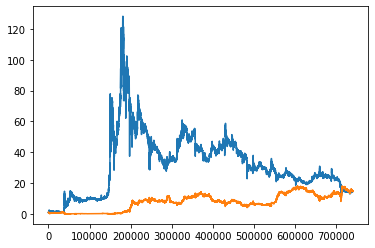

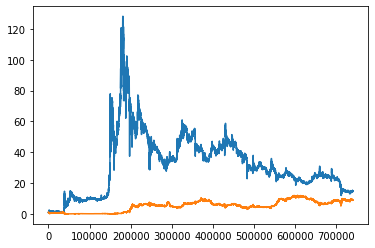

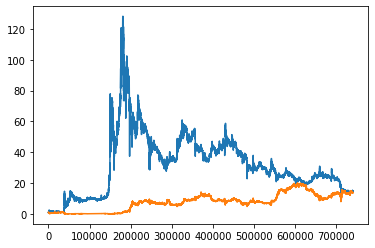

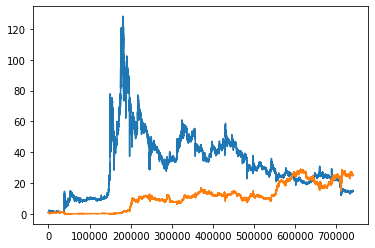

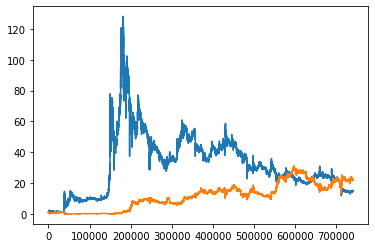

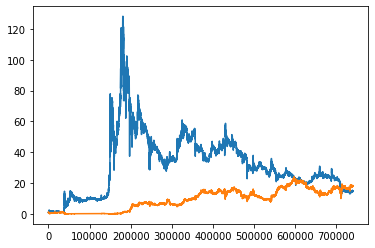

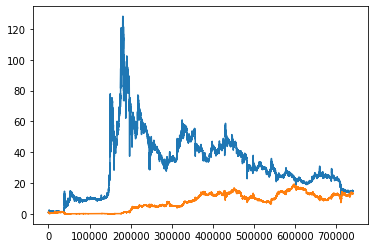

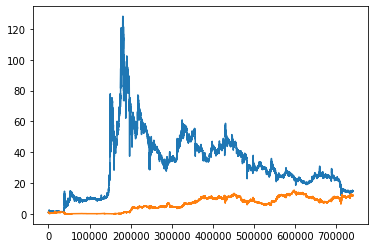

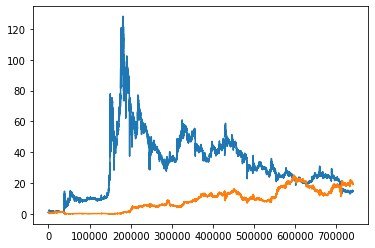

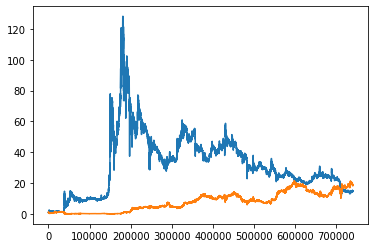

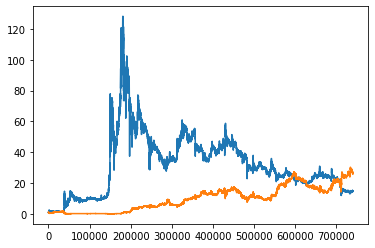

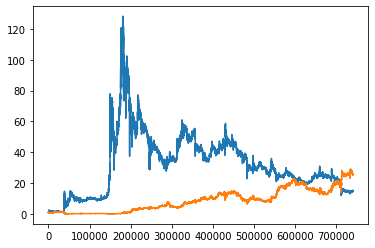

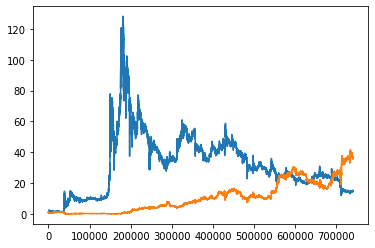

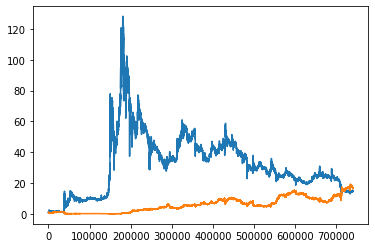

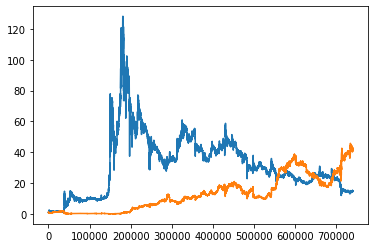

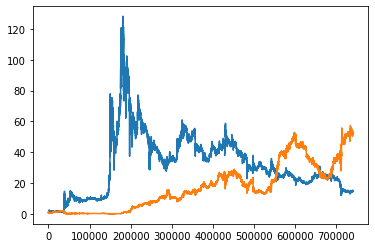

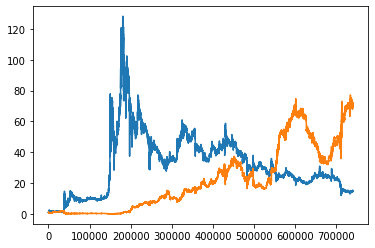

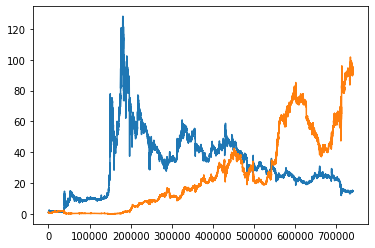

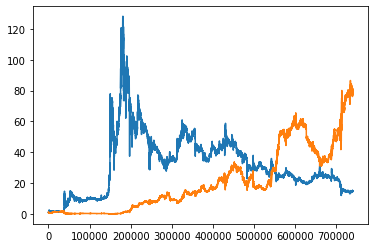

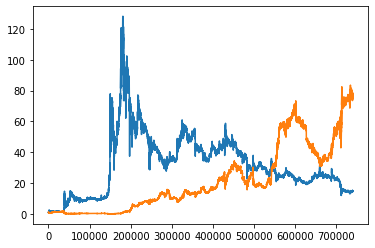

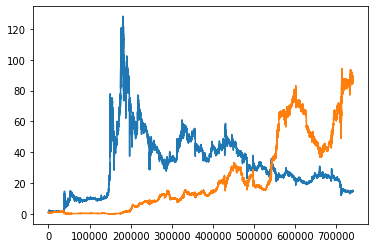

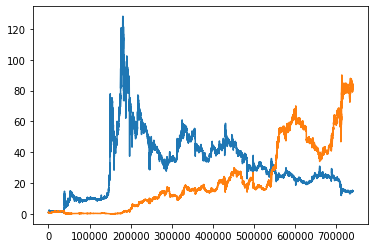

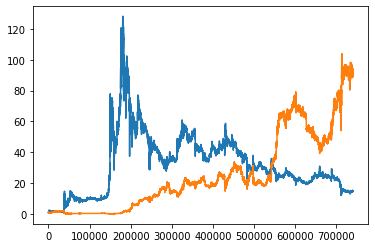

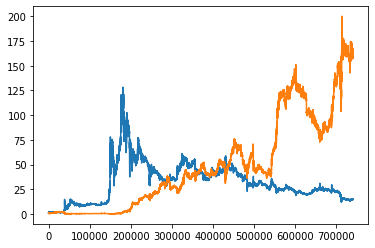

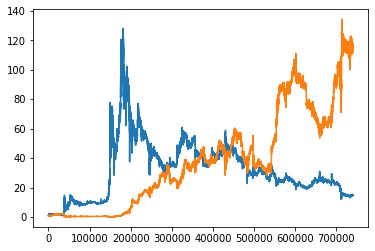

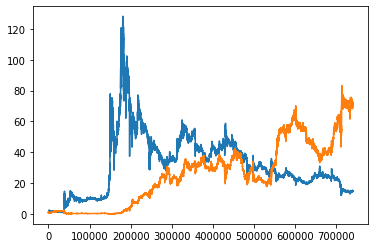

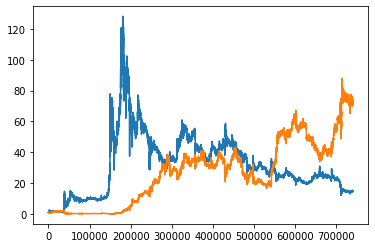

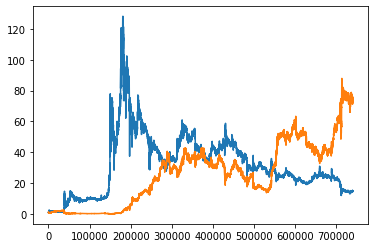

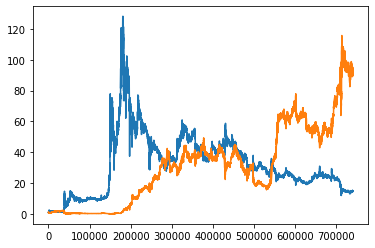

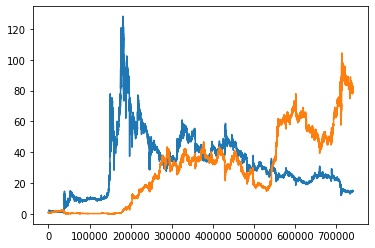

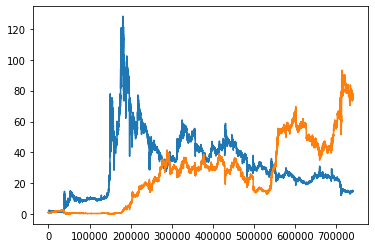

In [8]:
# threshold 최적화
yields = []
win_rates = []

fee_rate = 0.04 / 100
margin_rate = 1.0
limit_rate = 0.0
mul_threshold = 1.0 / 100
for i in range(100):
    threshold = [0.0 + mul_threshold * i, 0.0 - mul_threshold * i]
    trading_conditions = [fee_rate, margin_rate, threshold]
    trader = simulator.TraderFutureMarket(ohlcv_data, y_pred, trading_conditions)
    trading_info, money_list, value_list = trader.get_yield()
    win_rates.append(trading_info[2])
    yields.append((money_list[-1]/money_list[0] - 1) * 100)

    plt.clf()
    plt.plot(list(range(len(value_list))), value_list/value_list[0])
    plt.plot(list(range(len(money_list))), money_list/money_list[0])
    plt.show()

거래횟수: 1435, 1435 회
승률: 59.860627177700344, 62.64808362369338 %
수익률: 16323.08586330888 %


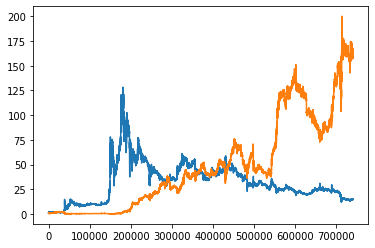

max_idx, max_yield:  92 16323.08586330888
threshold:  [0.92, -0.92]
limit_rate:  0.0


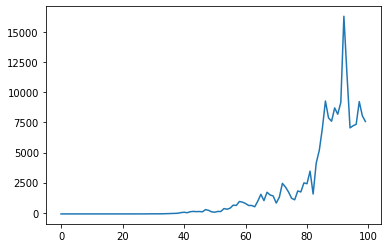

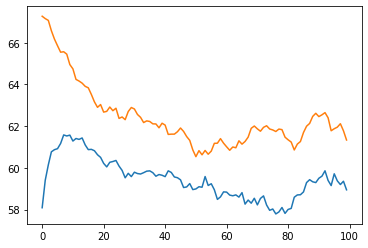

In [9]:
# threshold 최대 그래프 출력
max_idx = np.argmax(yields) 
max_yield = yields[max_idx]

threshold = [0.0 + mul_threshold * max_idx, 0.0 - mul_threshold * max_idx]
trading_conditions = [fee_rate, margin_rate, threshold]
trader = simulator.TraderFutureMarket(ohlcv_data, y_pred, trading_conditions)
trading_info, money_list, value_list = trader.get_yield()

print("거래횟수: %s, %s 회" % (trading_info[1][0], trading_info[1][1]))
print("승률: %s, %s %%" % (trading_info[2][0], trading_info[2][1]))
trading_yield = (money_list[-1]/money_list[0] - 1) * 100
print("수익률: %s %%" % trading_yield)

plt.clf()
plt.plot(list(range(len(value_list))), value_list/value_list[0])
plt.plot(list(range(len(money_list))), money_list/money_list[0])
plt.show()

print("max_idx, max_yield: ", max_idx, max_yield)
print("threshold: ", threshold)
print("limit_rate: ", limit_rate * 100)

plt.clf()
plt.plot(list(range(len(yields))), yields)
plt.show()

plt.clf()
plt.plot(list(range(len(win_rates))), win_rates)
plt.show()

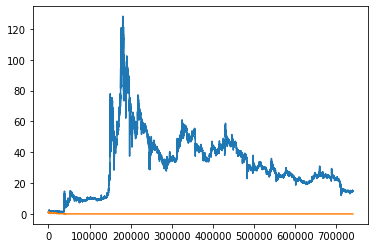

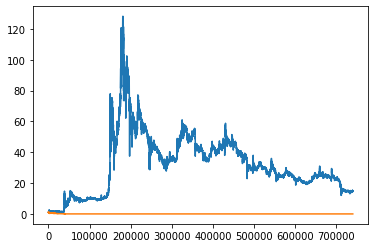

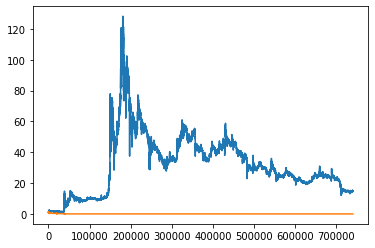

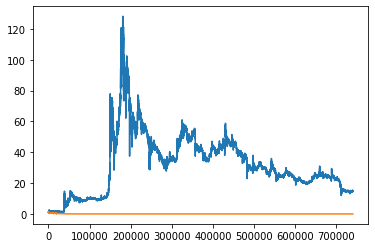

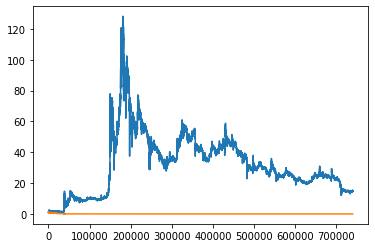

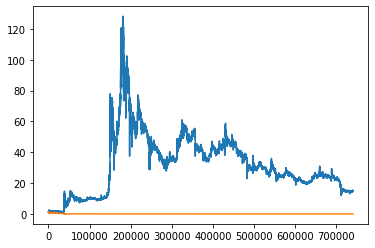

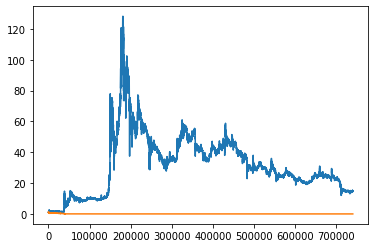

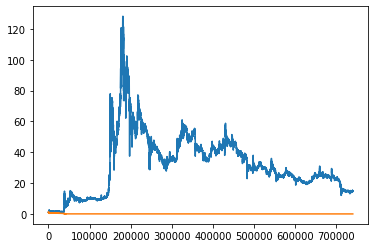

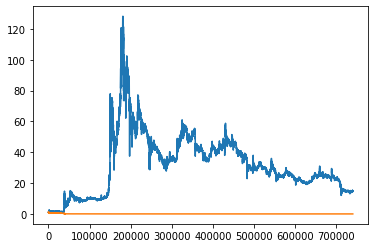

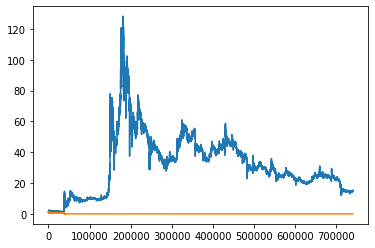

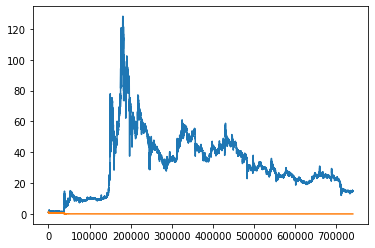

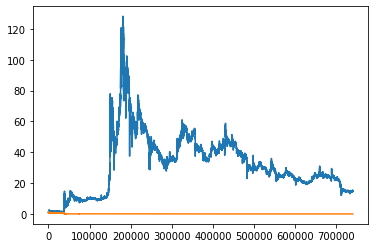

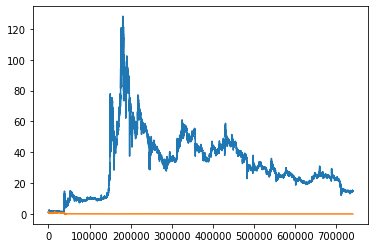

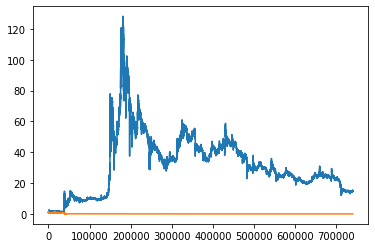

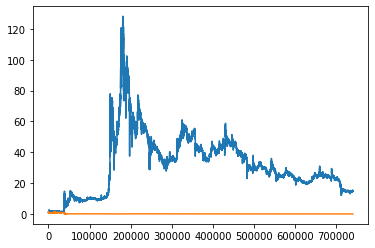

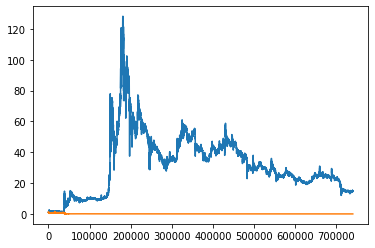

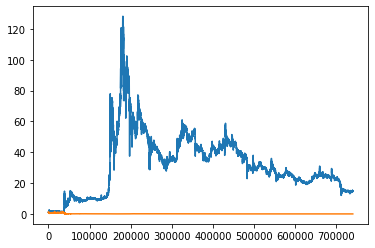

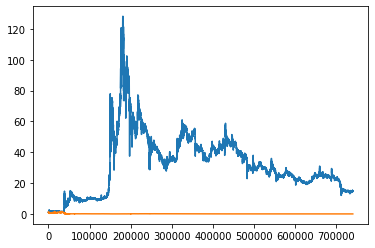

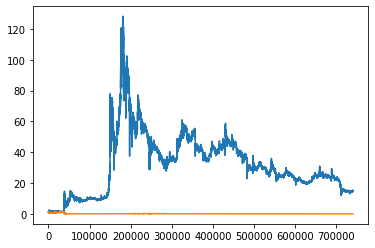

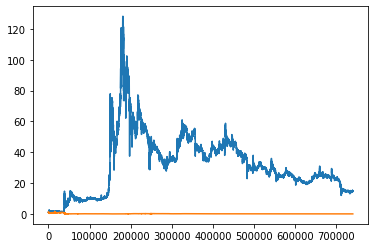

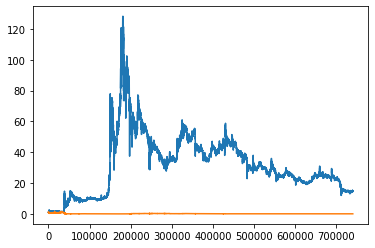

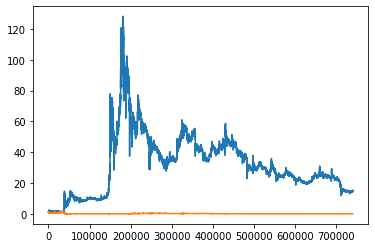

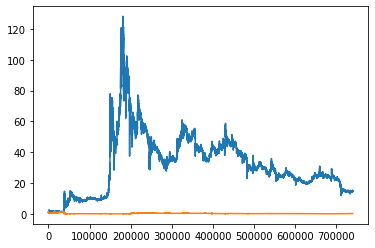

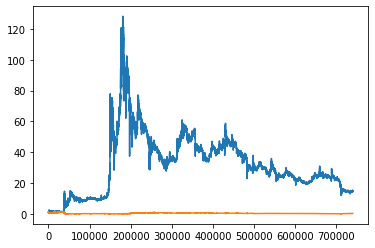

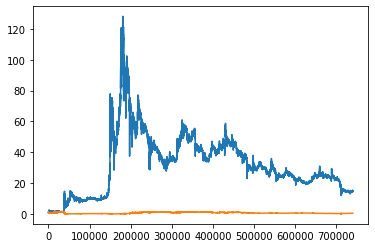

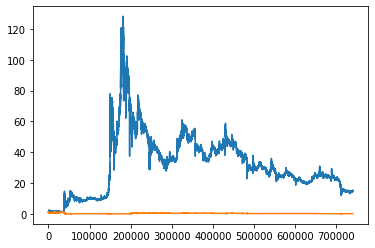

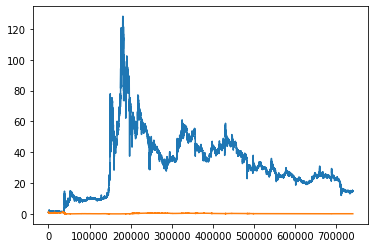

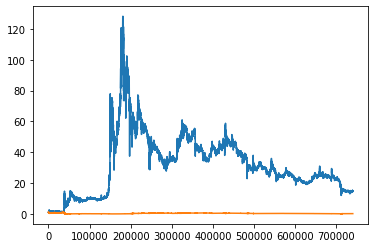

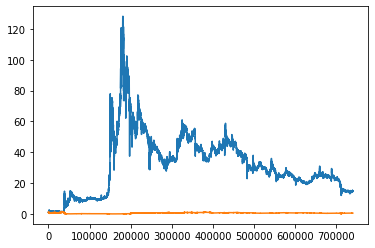

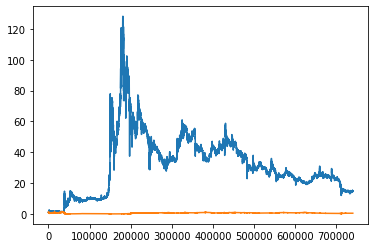

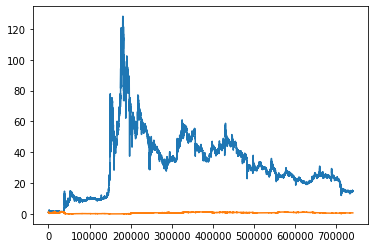

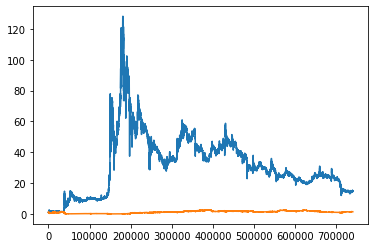

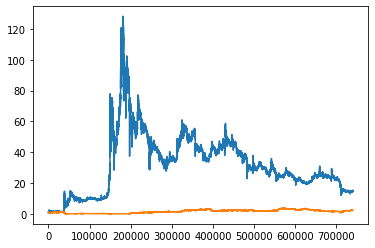

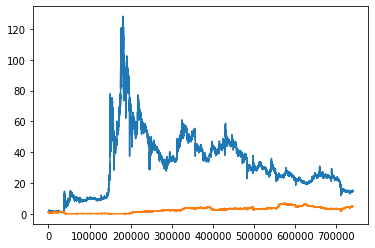

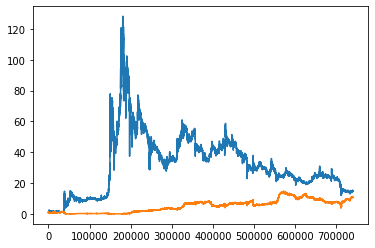

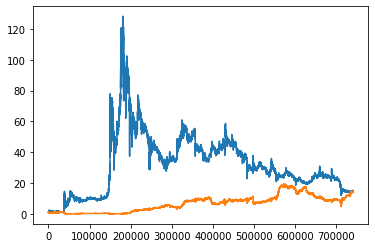

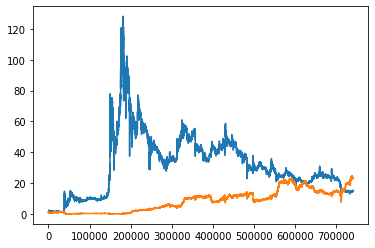

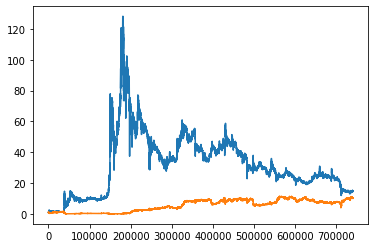

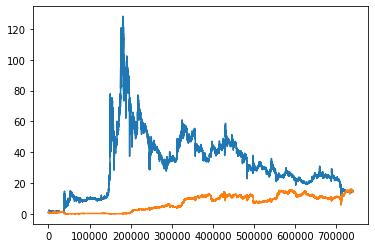

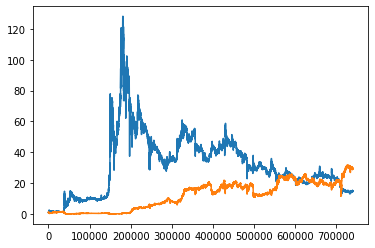

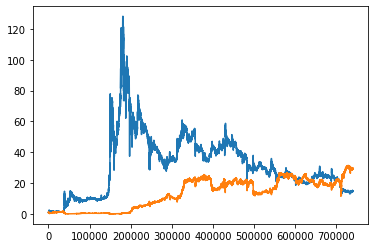

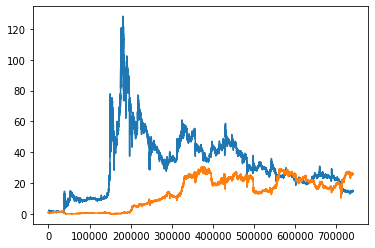

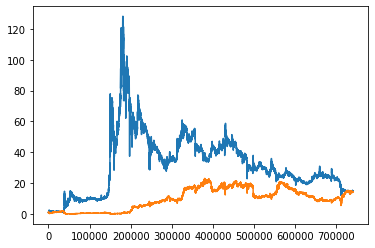

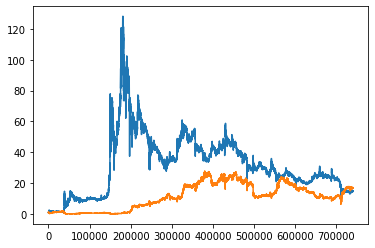

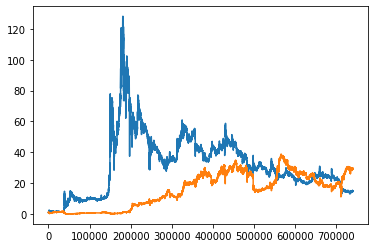

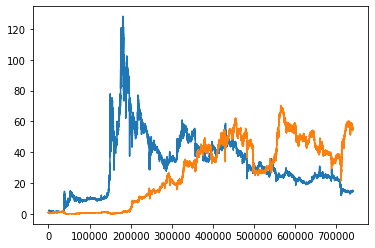

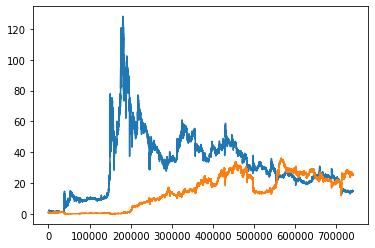

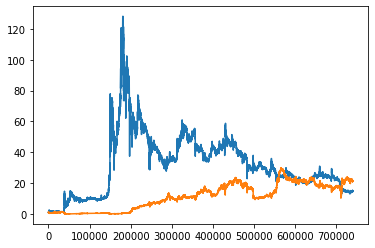

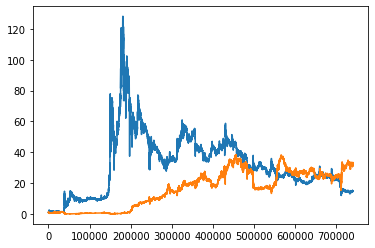

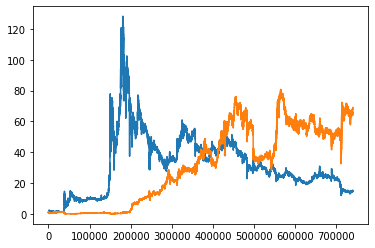

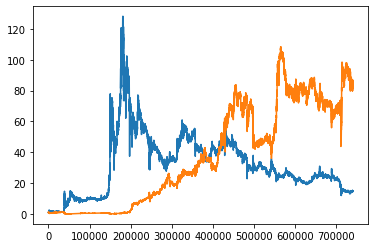

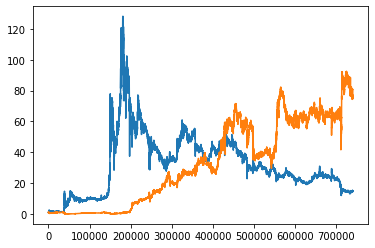

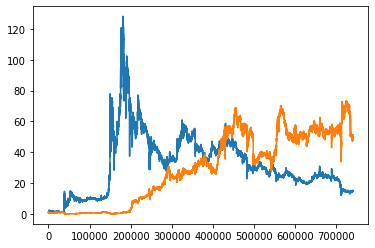

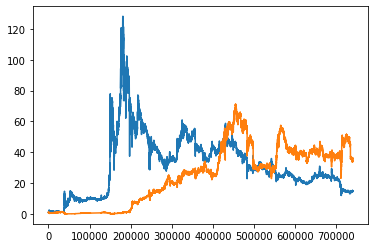

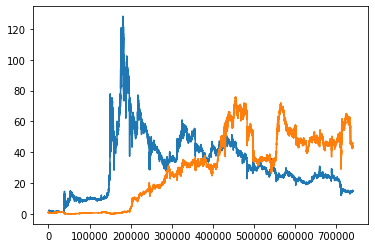

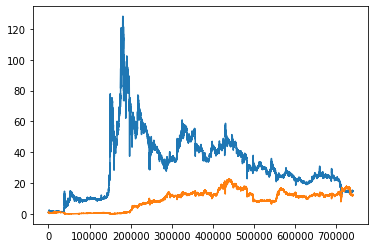

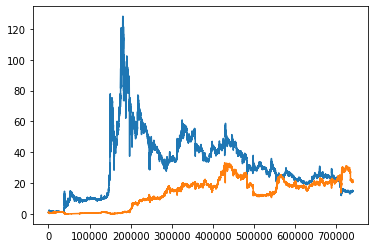

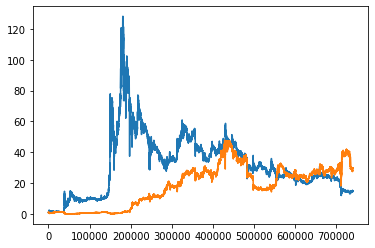

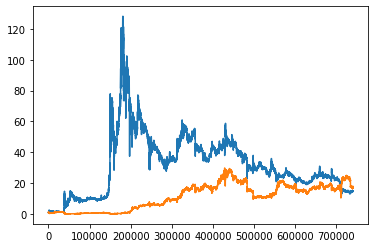

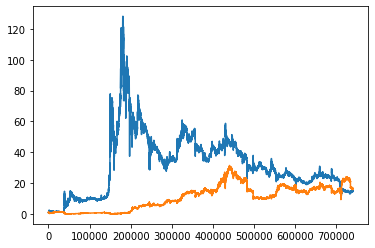

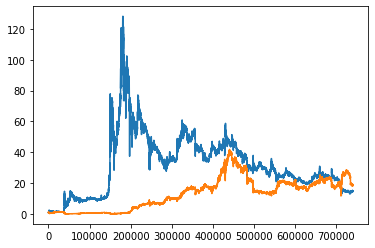

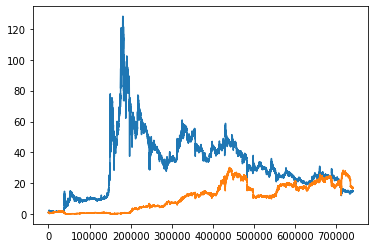

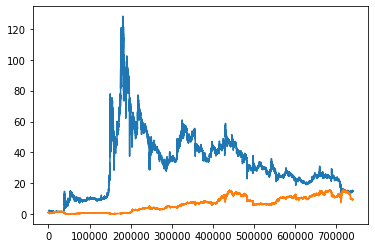

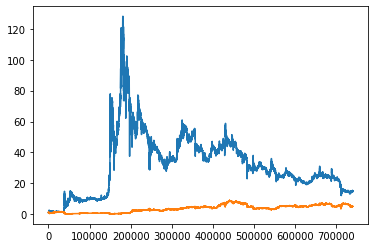

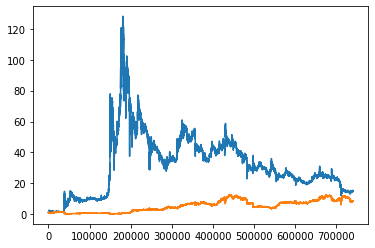

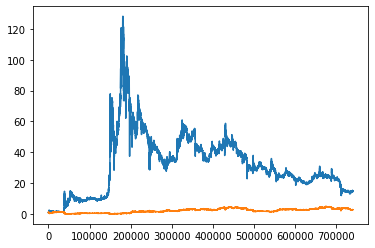

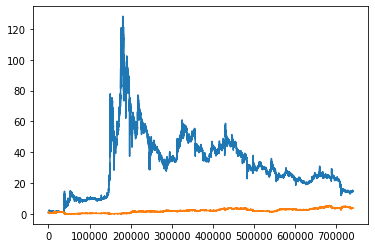

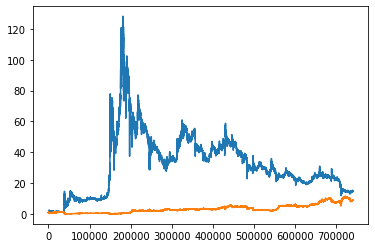

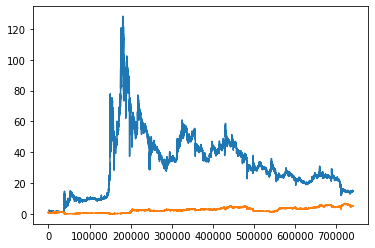

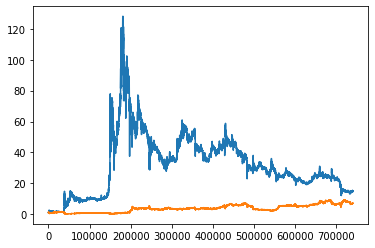

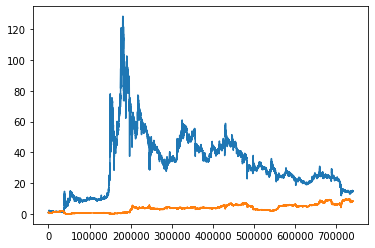

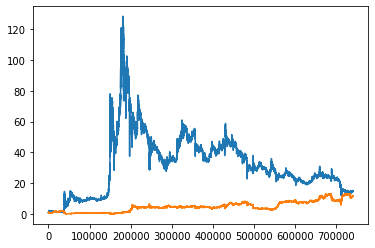

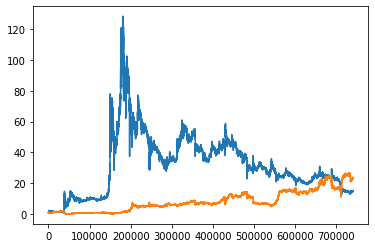

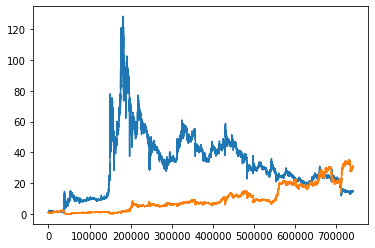

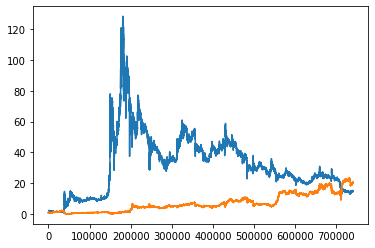

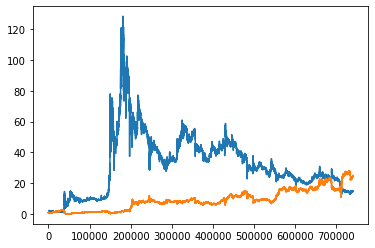

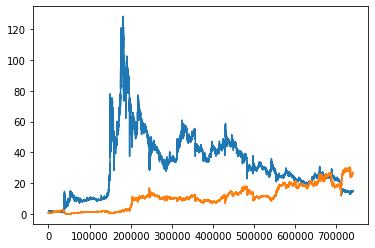

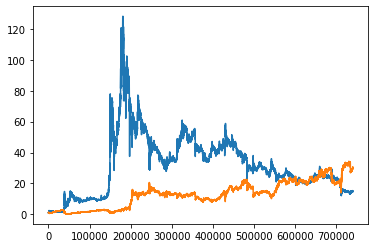

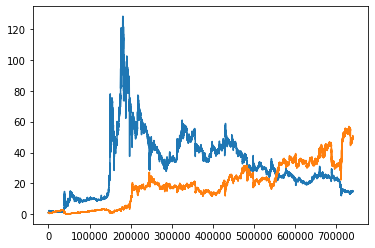

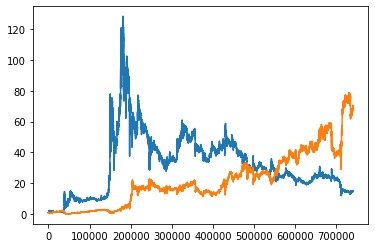

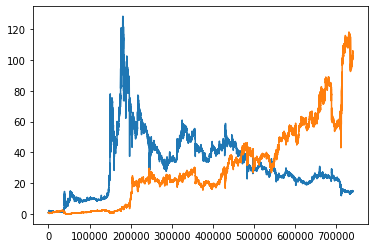

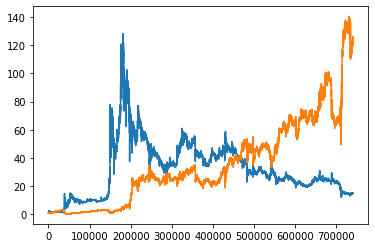

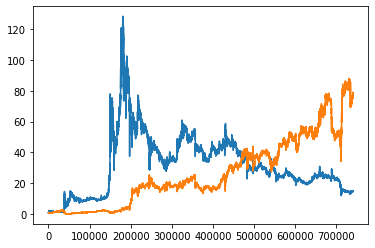

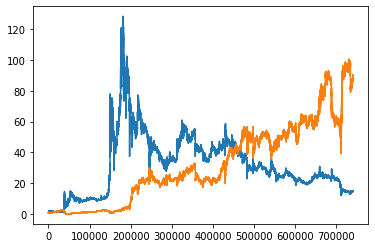

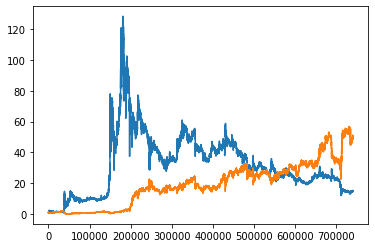

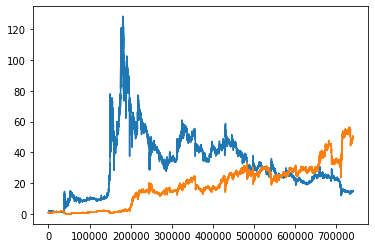

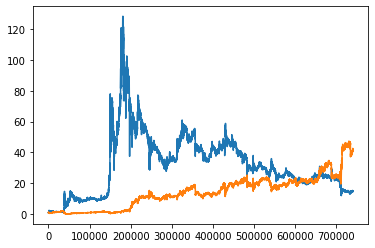

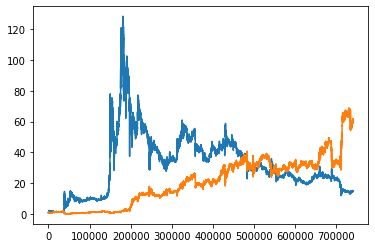

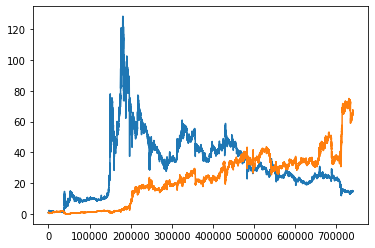

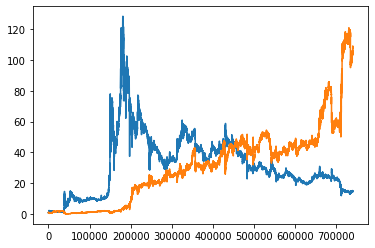

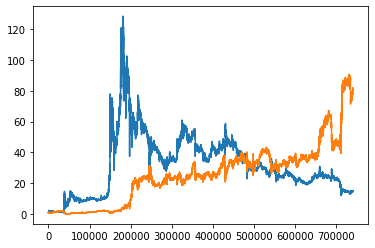

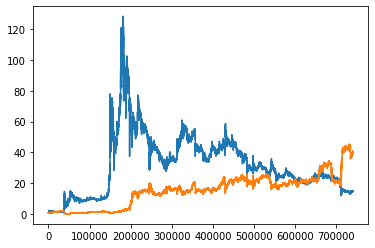

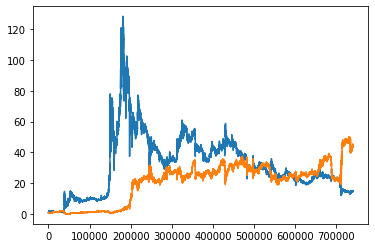

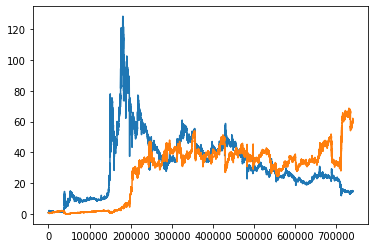

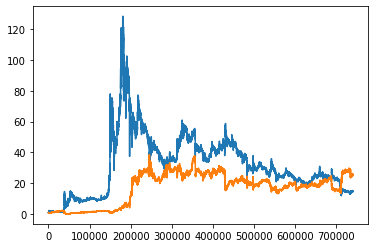

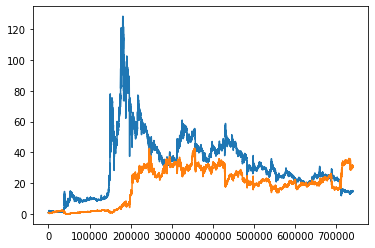

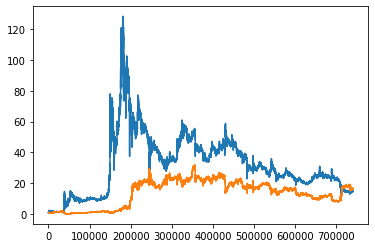

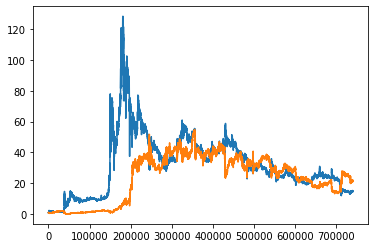

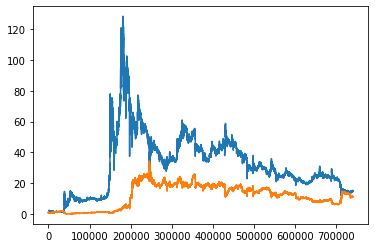

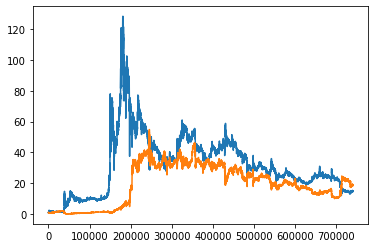

In [10]:
# limit_rate 최적화
yields = []
win_rates = []

fee_rate = 0.02 / 100
margin_rate = 1.0
threshold = [0.0, 0.0]
mul_limit_rate = 1.0 / 100
for i in range(100):
    limit_rate = mul_limit_rate * i / 100
    trading_conditions = [fee_rate, margin_rate, threshold, limit_rate]
    trader = simulator.TraderFutureLimit(ohlcv_data, y_pred, trading_conditions)
    trading_info, money_list, value_list = trader.get_yield()
    win_rates.append(trading_info[2])
    yields.append((money_list[-1]/money_list[0] - 1) * 100)

    plt.clf()
    plt.plot(list(range(len(value_list))), value_list/value_list[0])
    plt.plot(list(range(len(money_list))), money_list/money_list[0])
    plt.show()

거래횟수: 1090, 1079 회
승률: 63.30275229357798, 64.13345690454125 %
수익률: 12293.655578038573 %


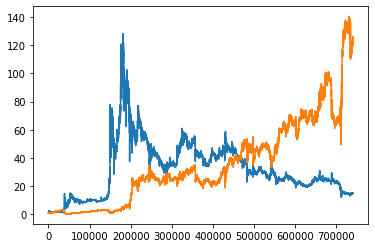

max_idx, max_yield:  81 12293.655578038573
threshold:  [0.0, 0.0]
limit_rate:  0.8100000000000002


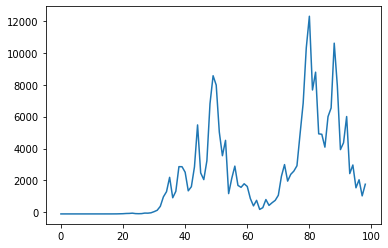

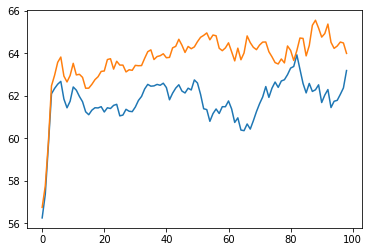

In [11]:
# limit rate 최대 그래프 출력
max_idx = np.argmax(yields[1:]) + 1
max_yield = yields[max_idx]

threshold = [0.0, 0.0]
limit_rate = mul_limit_rate * max_idx / 100

trading_conditions = [fee_rate, margin_rate, threshold, limit_rate]
trader = simulator.TraderFutureLimit(ohlcv_data, y_pred, trading_conditions)
trading_info, money_list, value_list = trader.get_yield()

print("거래횟수: %s, %s 회" % (trading_info[1][0], trading_info[1][1]))
print("승률: %s, %s %%" % (trading_info[2][0], trading_info[2][1]))
trading_yield = (money_list[-1]/money_list[0] - 1) * 100
print("수익률: %s %%" % trading_yield)

plt.clf()
plt.plot(list(range(len(value_list))), value_list/value_list[0])
plt.plot(list(range(len(money_list))), money_list/money_list[0])
plt.show()

print("max_idx, max_yield: ", max_idx, max_yield)
print("threshold: ", threshold)
print("limit_rate: ", limit_rate * 100)

plt.clf()
plt.plot(list(range(len(yields[1:]))), yields[1:])
plt.show()

plt.clf()
plt.plot(list(range(len(win_rates[1:]))), win_rates[1:])
plt.show()